# Мобильное приложение «Ненужные вещи» — Выделение групп пользователей на основе поведения

# Описание проекта:

***Пользователи нашего приложения совершают в нём много действий и в этих данных есть инсайты, которые позволят нам стать лучшим приложением для продажи ненужных вещей.***

***«Ненужные вещи» — ваши ненужные вещи нужны кому-то другому!***

# Основные задачи:

- ***Выбрать методику сегментации пользователей***

- ***Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?***

- ***Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?***

<a class="anchor" id="description"></a>

## Знакомство с данными и их предобработка

### Описание данных

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Датасет **mobile_dataset.csv** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

### Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(14, 7)})
import plotly.express as px
import math as mth
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from scipy import stats as st

### Загрузка данных и первичный осмотр <a class="anchor" id="dataload"></a>

In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

### Проверка на корректность наименований <a class="anchor" id="rightnames"></a>

In [3]:
mobile_sourсes.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


4293 строки, 2 столбца

In [5]:
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [6]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


74197 строк, 3 столбца

Приведем названия столбцов в датасетах к стандарту

In [7]:
mobile_sourсes.columns = ['user_id', 'source']
mobile_dataset.columns = ['event_time', 'event_name', 'user_id']

### Проверка на типы данных, приведение их в соответствие <a class="anchor" id="types"></a>

Типы данных все подходят, кроме event_time, приведем его к datetime формату и избавимся от милисекунд

In [8]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time']).dt.floor("S")
mobile_dataset.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


### Проверка на дубликаты и пропуски <a class="anchor" id="dublicates"></a>

In [9]:
mobile_sourсes.isna().sum()

user_id    0
source     0
dtype: int64

In [10]:
mobile_dataset.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [11]:
mobile_sourсes.duplicated().sum()

0

In [12]:
mobile_dataset.duplicated().sum()

1143

Дубликаты появились после округления до секунд, удалим их, так как маловероятно, что можно совершить два разных действия с разницей в милисекунды.

In [13]:
mob_df = mobile_dataset.drop_duplicates()
mob_df

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


Для дальнейшего исследования объединим два датасета в один

In [14]:
df = mob_df.merge(mobile_sourсes, on='user_id', how='left')
df

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
...,...,...,...,...
73049,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
73050,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
73051,2019-11-03 23:56:57,search_1,20850c8f-4135-4059-b13b-198d3ac59902,google
73052,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google


### Изучим полученные данные более детально <a class="anchor" id="data_details"></a>

In [15]:
df['source'].value_counts()

yandex    33845
google    20158
other     19051
Name: source, dtype: int64

В данных всего 3 источника: Яндекс, Гугл и все остальные

In [16]:
print('Количество уникальных пользователей:', df['user_id'].nunique())

Количество уникальных пользователей: 4293


In [17]:
df['event_time'].describe()

count                   73054
unique                  71291
top       2019-10-22 13:00:04
freq                        4
first     2019-10-07 00:00:00
last      2019-11-03 23:58:12
Name: event_time, dtype: object

In [18]:
print('Располагаем данными за:', df['event_time'].max() - df['event_time'].min())

Располагаем данными за: 27 days 23:58:12


У нас имеются данные с 07 октября по 03 ноября 2019 года, почти 28 дней

In [19]:
df['event_name'].value_counts()

tips_show        39907
photos_show       9352
advert_open       6146
contacts_show     4297
map               3749
search_1          3488
favorites_add     1414
search_5          1049
tips_click         811
search_4           701
contacts_call      534
search_3           521
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

События contacts_show и show_contacts по техническому заданию - это одно и тоже событие, поэтому объединим их

In [20]:
df.loc[df['event_name']=='show_contacts', 'event_name'] = 'contacts_show'

События search_1 - search_7 судя по заданию, можно также объединить в одно

In [21]:
df.duplicated().sum()

0

In [22]:
def rename(name):
    if 'search_' in name:
        return 'search'
    else: 
        return name

In [23]:
df['event_name']=df['event_name'].apply(rename)

In [24]:
df['event_name'].value_counts()

tips_show        39907
photos_show       9352
search            6765
advert_open       6146
contacts_show     4376
map               3749
favorites_add     1414
tips_click         811
contacts_call      534
Name: event_name, dtype: int64

In [25]:
df.duplicated().sum()

81

После объединения поисков снова появились дубликаты, можно их удалить, так как их очень мало в общей массе

In [26]:
df = df.drop_duplicates()
df

,event_time,event_name,user_id,source
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
...,...,...,...,...
73049,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
73050,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google
73051,2019-11-03 23:56:57,search,20850c8f-4135-4059-b13b-198d3ac59902,google
73052,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google


In [27]:
df.duplicated().sum()

0

Добавим отдельный столбец только с датой события

In [28]:
df['event_date'] = df['event_time'].astype('datetime64[D]')
df

,event_time,event_name,user_id,source,event_date
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
...,...,...,...,...,...
73049,2019-11-03 23:53:29,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03
73050,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03
73051,2019-11-03 23:56:57,search,20850c8f-4135-4059-b13b-198d3ac59902,google,2019-11-03
73052,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-11-03


In [29]:
df['event_date_graph'] = df['event_time'].dt.date

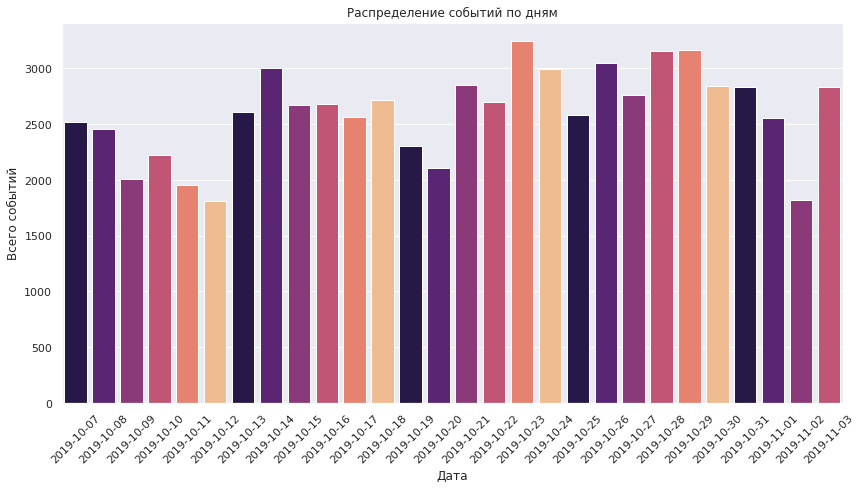

In [30]:
events_by_days = df.groupby('event_date_graph')[['event_name']].count().reset_index()

plt.figure(figsize = (14,7))
sns.barplot(
    x='event_date_graph', 
    y='event_name', 
    data=events_by_days, 
    palette = sns.color_palette('magma')
)
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Всего событий')
plt.title('Распределение событий по дням')
plt.show()

События распределены по дням более менее равномерно, можно работать с данными

### Промежуточный вывод <a class="anchor" id="opinion1"></a>

Проверили на корректность наименований, на типы данных, на дубликаты и пропуски - привели их в соответствие.

У нас имеются данные с 07 октября по 03 ноября 2019 года, почти 28 дней.

4293 уникальных пользователей.

События среди пользователей распределены равномерно по дням исследования.

## Исследовательский анализ данных <a class="anchor" id="eda"></a>

### Retention rate <a class="anchor" id="rr"></a>

*Необходимо разделить пользователей по когортам, для этого определим, когда пользователь впервые совершил событие*

In [31]:
first_date = df.groupby(['user_id'])['event_date'].min()
first_date.name = 'start_dt'

df_active = df.join(first_date,on='user_id')

In [32]:
df_active.sample(5)

,event_time,event_name,user_id,source,event_date,event_date_graph,start_dt
39875,2019-10-23 12:07:35,photos_show,436f9097-0be9-46dc-ab8d-e25e2540d61e,yandex,2019-10-23,2019-10-23,2019-10-23
46284,2019-10-25 13:06:39,tips_show,e0e93278-71b3-4f68-951f-ded06fdc237f,yandex,2019-10-25,2019-10-25,2019-10-14
68346,2019-11-01 22:55:09,tips_show,68d999c5-9101-4715-b307-fc7cd53947b2,other,2019-11-01,2019-11-01,2019-10-26
67763,2019-11-01 19:34:32,advert_open,da2f205b-a241-44a0-98e8-39009c400b3c,google,2019-11-01,2019-11-01,2019-10-30
46991,2019-10-25 17:14:56,tips_show,82ee44d2-149b-407d-83af-83503d103631,google,2019-10-25,2019-10-25,2019-10-21


In [33]:
df_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72973 entries, 0 to 73053
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   event_time        72973 non-null  datetime64[ns]
 1   event_name        72973 non-null  object        
 2   user_id           72973 non-null  object        
 3   source            72973 non-null  object        
 4   event_date        72973 non-null  datetime64[ns]
 5   event_date_graph  72973 non-null  object        
 6   start_dt          72973 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(4)
memory usage: 4.5+ MB


Найдем когорту, получим день начала недели, за которую произошло событие

In [34]:
df_active['active_week'] = pd.to_datetime(df_active['event_date'],
                                                unit='d') - pd.to_timedelta(df_active['event_date'].dt.dayofweek, unit='d')
df_active['start_week'] = pd.to_datetime(df_active['start_dt'],
                                                      unit='d') - pd.to_timedelta(df_active['start_dt'].dt.dayofweek, unit='d')

Теперь можно определить lifetime пользователя

In [35]:
df_active['cohort_lifetime'] = df_active['active_week'] - df_active['start_week']
df_active['cohort_lifetime'] = df_active['cohort_lifetime'] / np.timedelta64(1,'W')
df_active['cohort_lifetime'] = df_active['cohort_lifetime'].astype(int)

Группировка по когорте и lifetime 

In [36]:
cohorts = df_active.groupby(['start_week','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

Определим число пользователей в когорте за нулевую неделю

In [37]:
users_count = cohorts[cohorts['cohort_lifetime'] == 0][['start_week','user_id']]

In [38]:
users_count = users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(users_count, on='start_week')

Рассчитаем Retention Rate

In [39]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']

In [40]:
cohorts['start_week'] = cohorts['start_week'].dt.date

In [41]:
retention_pivot = cohorts.pivot_table(index='start_week',columns='cohort_lifetime',values='retention',aggfunc='sum')

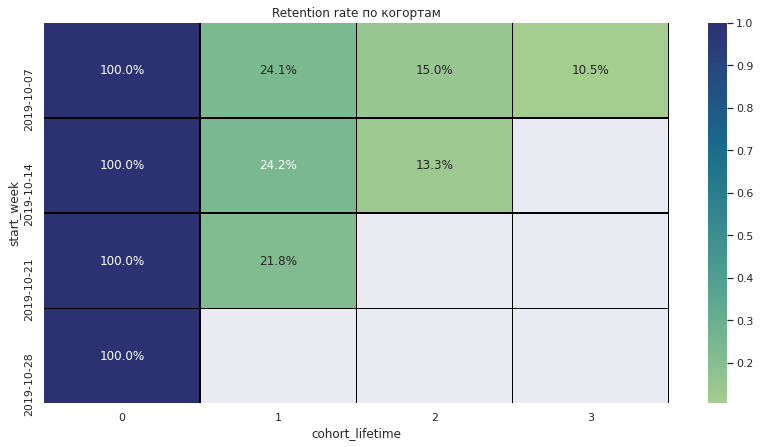

In [42]:
plt.figure(figsize=(14, 7))
plt.title('Retention rate по когортам')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=0.2, linecolor='black', cmap="crest");

Мы видим, как коэффициент удержания в первую неделю убывает по когортам. С 7 октября по 13 октября Retention Rate в первую неделю составляет 24,1%, с 21 по 27 октября — уже 21,8%. Поведение покупателей меняется с каждой неделей, но из-за недостаточного промежутка времени в исследовании, возможна погрешность и выводы поверхностны

### Время, проведённое в приложении <a class="anchor" id="timeapp"></a>

Необходимо выделить сессии для каждого пользователя, примем 40 минут за одну сессию

In [43]:
df = df.sort_values(['user_id', 'event_time'])

In [44]:
session = ((df.groupby('user_id')['event_time'].diff() > pd.Timedelta('40Min')).cumsum())

In [45]:
df['session_id'] = df.groupby(['user_id', session], sort=False).ngroup() + 1
df.head(15)

,event_time,event_name,user_id,source,event_date,event_date_graph,session_id
792,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
793,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
796,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
807,2019-10-07 13:43:20,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
816,2019-10-07 13:45:30,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
817,2019-10-07 13:45:43,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
818,2019-10-07 13:46:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
822,2019-10-07 13:47:32,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
825,2019-10-07 13:49:41,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07,2019-10-07,1
6464,2019-10-09 18:33:55,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-09,2019-10-09,2


Длительность сессий

In [46]:
session_duration = pd.DataFrame(df.groupby(['user_id', 'session_id'])['event_time'].
     max() - df.groupby(['user_id', 'session_id'])['event_time'].min()).reset_index()
session_duration

,user_id,session_id,event_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,0 days 00:09:56
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,0 days 00:08:27
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,0 days 00:15:00
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,0 days 00:12:38
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,0 days 00:25:21
...,...,...,...
10024,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10025,0 days 00:00:00
10025,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10026,0 days 00:16:14
10026,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10027,0 days 00:04:57
10027,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10028,0 days 00:15:49


Продолжительность сессии в минутах

In [47]:
session_duration['session_min'] = round((session_duration['event_time'].astype('timedelta64[s]')/60),2)
session_duration = session_duration.drop(columns=['event_time'])
session_duration

,user_id,session_id,session_min
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,9.93
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,8.45
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,15.00
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,12.63
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,25.35
...,...,...,...
10024,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10025,0.00
10025,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10026,16.23
10026,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10027,4.95
10027,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10028,15.82


Общее время в приложении, проведенное пользователями и среднее время

In [48]:
user_time_duration = (session_duration.groupby(['user_id'])['session_min'].agg({'sum', 'mean'}).reset_index())
user_time_duration.columns = ['user_id', 'mean', 'sum']
user_time_duration.head()

,user_id,mean,sum
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,46.01,11.502500
1,00157779-810c-4498-9e05-a1e9e3cedf93,196.23,32.705000
2,00463033-5717-4bf1-91b4-09183923b9df,24.70,24.700000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,110.73,18.455000
4,00551e79-152e-4441-9cf7-565d7eb04090,9.32,3.106667


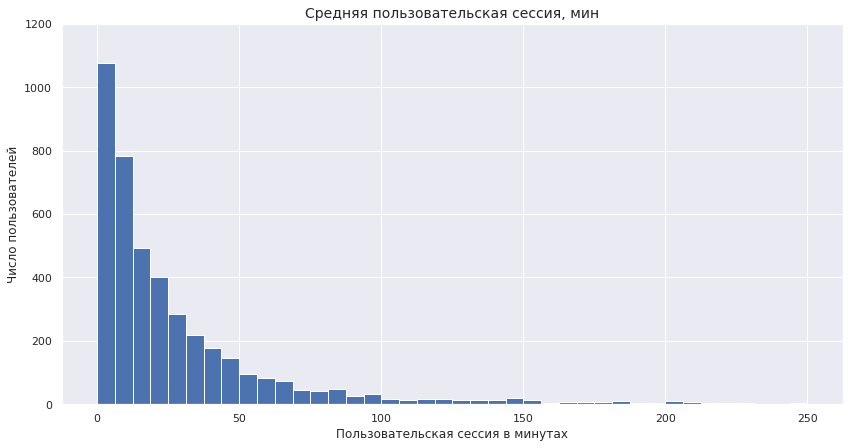

In [49]:
user_time_duration['mean'].hist(bins = 40, figsize = (14, 7), range = (0, 250))
plt.title('Средняя пользовательская сессия, мин', fontsize=14)
plt.xlabel('Пользовательская сессия в минутах', fontsize=12)
plt.ylabel('Число пользователей', fontsize=12)
plt.ylim(0, 1200);

In [50]:
user_time_duration.describe()

,mean,sum
count,4293.000000,4293.000000
mean,33.833468,15.887301
std,70.052331,18.562706
min,0.000000,0.000000
25%,6.230000,4.285000
50%,15.770000,10.000000
75%,36.230000,21.017000
max,1890.210000,222.970000


Возьмем во внимание медианное значение, получилось что пользователь тратит где-то 15-16 минут на приложение за сессию.

### Частота действий <a class="anchor" id="actions"></a>

Посмотрим, какие события становятся первыми для полученных сессий

In [51]:
first_events = df.groupby('session_id').agg({'event_name': 'first'})['event_name'].value_counts().to_frame()
first_events

,event_name
tips_show,3636
search,2463
photos_show,1611
map,1266
contacts_show,520
advert_open,387
favorites_add,102
tips_click,44


Такими событиями стали: **tips_show** - "пользователь увидел рекомендованные объявления", **search** - "разные события, связанные с поиском по сайту", **photos_show** - "просмотр фотографий в объявлении" и **map** - "пользователь открыл карту размещенных объявлений"

Какие события чаще всего совершают пользователи

In [52]:
freq_events = df['event_name'].value_counts().to_frame()
freq_events

,event_name
tips_show,39907
photos_show,9352
search,6684
advert_open,6146
contacts_show,4376
map,3749
favorites_add,1414
tips_click,811
contacts_call,534


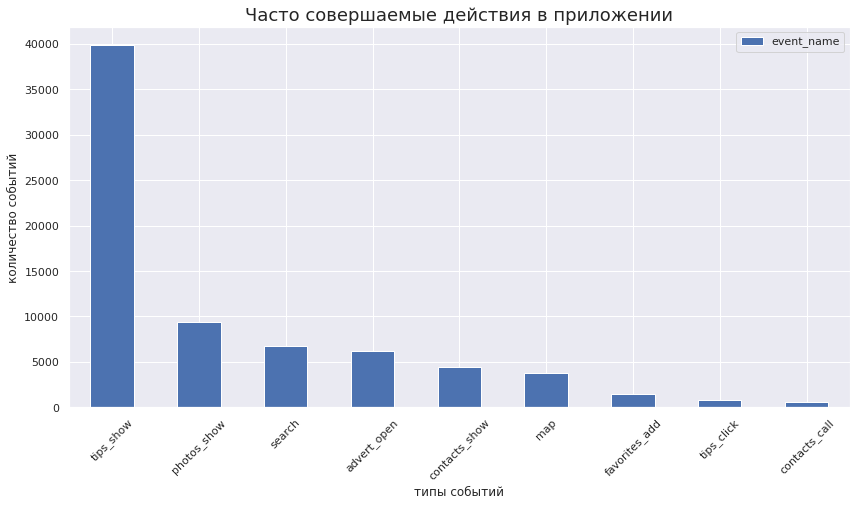

In [53]:
freq_events.plot(kind='bar', figsize=(14,7))
plt.title('Часто совершаемые действия в приложении', fontsize=18)
plt.gca().set(xlabel='типы событий', ylabel='количество событий')
plt.xticks(rotation=45)
plt;

Самые частые события - это **tips_show** пользователь увидел рекомендованные объявления, **photos_show** - просмотр фотографий в объявлении, **search** - поиск по сайту, **advert_open** - открытие карточки объявления.

### Конверсия в целевое действие — просмотр контактов <a class="anchor" id="conv_show_contacts"></a>

Сгруппируем данные по пользователям и номеру сессии и посчитаем число визитов

In [54]:
visits = df.groupby('user_id', as_index=False)\
.agg({'event_date':'count'})\
.rename(columns={'event_date':'visits'})
visits.head()

,user_id,visits
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8


Посчитаем, сколько раз пользователи совершили целевое действие - просмотр контактов

In [55]:
conversion = df.query('event_name=="contacts_show"')\
.groupby('user_id', as_index=False)\
.agg({'event_name':'count'})\
.rename(columns={'event_name':'conversions'})
conversion

,user_id,conversions
0,00157779-810c-4498-9e05-a1e9e3cedf93,11
1,00551e79-152e-4441-9cf7-565d7eb04090,3
2,005fbea5-2678-406f-88a6-fbe9787e2268,3
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,1
4,007d031d-5018-4e02-b7ee-72a30609173f,2
...,...,...
976,fee3ba1c-16f4-46f7-bf56-4bf80cc4e2f5,17
977,ff1554b5-919e-40b1-90bb-ee1f7f6d5846,1
978,ffc01466-fdb1-4460-ae94-e800f52eb136,1
979,ffe68f10-e48e-470e-be9b-eeb93128ff1a,1


In [56]:
visits = pd.merge(visits, conversion, on='user_id', how='left')

In [57]:
visits

,user_id,visits,conversions
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35,NaN
1,00157779-810c-4498-9e05-a1e9e3cedf93,71,11.0
2,00463033-5717-4bf1-91b4-09183923b9df,10,NaN
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32,NaN
4,00551e79-152e-4441-9cf7-565d7eb04090,8,3.0
...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17,NaN
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,7,1.0
4290,ffcf50d9-293c-4254-8243-4890b030b238,2,NaN
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,13,1.0


Заполним пропуски нулями

In [58]:
visits['conversions'] = visits['conversions'].fillna(0)

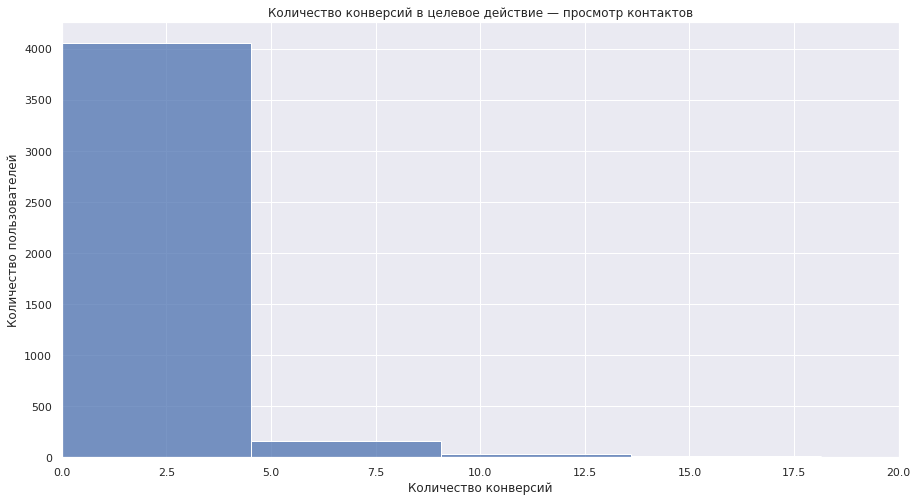

[ 2.  5. 15.]


In [59]:
plt.figure(figsize=(15, 8))
sns.histplot(visits['conversions'], bins=30)
plt.title('Количество конверсий в целевое действие — просмотр контактов')
plt.xlabel('Количество конверсий')
plt.ylabel('Количество пользователей')
plt.xlim(0, 20)
plt.show()
print(np.percentile(visits['conversions'], [90, 95, 99]))

*На каждого пользователя приходится от одной до 5 сессий;
Большая часть пользователей не совершает целевое действие - просмотр контактов.*

*Вычислим конверсию в действие contacts_show, отфильтруем основной датафрейм. Затем найдем уникальных пользователей в отфильтрованном датафрейме*

In [60]:
contacts_show_df = df.query('event_name == "contacts_show"')

In [61]:
contacts_show_df['user_id'].nunique()

981

In [62]:
(contacts_show_df['user_id'].nunique() / df['user_id'].nunique()) * 100

22.851153039832283

### Вывод после исследовательского анализа данных <a class="anchor" id="opinion2"></a>

- Поведение покупателей меняется с каждой неделей и **retention rate** уменьшается, но из-за недостаточного промежутка времени в исследовании, возможна погрешность и выводы поверхностны;


- Пользователь тратит где-то 15-16 минут на приложение за сессию, на каждого пользователя приходится от 1 до 5 сессий;

- Самые частые события - это **tips_show** пользователь увидел рекомендованные объявления, **photos_show** - просмотр фотографий в объявлении, **search** - поиск по сайту, **advert_open** - открытие карточки объявления;

- По нашим расчетам до события **contacts_show** доходят ~23% пользователей. 77% - достаточно большой отток от общего количества пришедших к нам пользователей. Возможно управление приложением не достаточно интуитивно и пользователь путается в большом количестве рекомендаций и приложение нужно как-то упростить.

## Выбор сегментации пользователей, на основе их действий <a class="anchor" id="segment"></a>

### Разделим пользователей на группы в зависимости от их активности и достижения целевого действия <a class="anchor" id="segment2"></a>

*Данное разделение позволит понять нам, насколько влияет активность пользователей в приложении на их конечный результат (целевое действие - просмотр контакта), если он есть вообще. Либо же их активность вообще ни на что не влияет и не важно, много или мало они тратят времени в приложении. К примеру, пользователь зашел, сразу зная, чего он хочет и если не обнаружил интересуемого объявления, то вышел, не совершив целевого действия **ИЛИ** наоборот - нашел объявление ---> совершил целевое действие ---> вышел из приложения, потратив минимум времени. Может быть и другой вариант, чем больше тратит времени, тем выше шанс получить желаемый результат.*

*Давайте попробуем разобраться.*

In [63]:
last_visits = df.groupby(['user_id'])['event_date'].max().reset_index()
last_visits.columns = ['user_id', 'last_dt']

In [64]:
df = df.merge(last_visits, on='user_id')

In [65]:
df['duration'] = (df['last_dt'] - df['event_date']).dt.days + 1

ЗАДАДИМ ФУНКЦИЮ, в которой промаркируем пользователей, совершивших интересующее нас событие(ставим 1). При группировке по пользователю можно сложить единицы, узнав сколько раз пользователь посмотрел контакты и увидеть, совершалось ли вообще пользователем какое-то событие.

In [66]:
def markers(name):

    df[name] = ""
    for i in range(len(df['event_name'])):
        if df['event_name'][i] == name:
            df[name][i] = 1
        else:
            df[name][i] = 0

Выберем наиболее популярные события (процесс в обработке займет некоторое время)

In [67]:
markers('contacts_show')

In [68]:
markers('photos_show')

In [69]:
markers('tips_show')

In [70]:
markers('search')

In [71]:
df.sample(5)

,event_time,event_name,user_id,source,event_date,event_date_graph,session_id,last_dt,duration,contacts_show,photos_show,tips_show,search
70563,2019-10-28 09:04:22,photos_show,f7ebe532-628f-474e-9a99-74ccd6880373,yandex,2019-10-28,2019-10-28,9705,2019-10-28,1,0,1,0,0
37448,2019-10-26 17:36:03,tips_show,8838c496-799c-48b9-9db9-f1415761ee69,other,2019-10-26,2019-10-26,5324,2019-10-26,1,0,0,1,0
68566,2019-10-18 19:20:03,tips_show,f06b73ca-9f77-4509-8c1d-c2cad213746d,google,2019-10-18,2019-10-18,9408,2019-10-18,1,0,0,1,0
7373,2019-10-09 13:20:22,tips_show,17171949-e046-4620-be96-dcfca0fd7a5c,yandex,2019-10-09,2019-10-09,1035,2019-10-09,1,0,0,1,0
40799,2019-10-26 13:36:20,tips_show,96cef8c5-327f-49f4-98ec-cb1d9a931d48,yandex,2019-10-26,2019-10-26,5794,2019-10-28,3,0,0,1,0


In [72]:
user_groups = df.groupby('user_id').agg({'duration':'mean', 
                                                          'session_id':'count', 
                                                          'event_name':'count',
                                                          'contacts_show':'sum', 
                                                          'photos_show':'max',
                                                          'tips_show':'max',
                                                          'search':'max'})

user_groups

,duration,session_id,event_name,contacts_show,photos_show,tips_show,search
user_id,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,6.742857,35,35,0,0,1,0
00157779-810c-4498-9e05-a1e9e3cedf93,9.915493,71,71,11,1,0,1
00463033-5717-4bf1-91b4-09183923b9df,1.000000,10,10,0,1,0,0
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6.718750,32,32,0,0,1,1
00551e79-152e-4441-9cf7-565d7eb04090,2.625000,8,8,3,1,0,1
...,...,...,...,...,...,...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,8.647059,17,17,0,0,1,0
ffc01466-fdb1-4460-ae94-e800f52eb136,1.000000,7,7,1,1,0,0
ffcf50d9-293c-4254-8243-4890b030b238,1.000000,2,2,0,0,1,0


### Считаем конверсию для каждой из групп <a class="anchor" id="conv_group"></a>

In [73]:
user_groups['conversion'] = (user_groups['contacts_show']/user_groups['session_id']).round(2)
user_groups

,duration,session_id,event_name,contacts_show,photos_show,tips_show,search,conversion
user_id,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,6.742857,35,35,0,0,1,0,0.00
00157779-810c-4498-9e05-a1e9e3cedf93,9.915493,71,71,11,1,0,1,0.15
00463033-5717-4bf1-91b4-09183923b9df,1.000000,10,10,0,1,0,0,0.00
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6.718750,32,32,0,0,1,1,0.00
00551e79-152e-4441-9cf7-565d7eb04090,2.625000,8,8,3,1,0,1,0.38
...,...,...,...,...,...,...,...,...
ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,8.647059,17,17,0,0,1,0,0.00
ffc01466-fdb1-4460-ae94-e800f52eb136,1.000000,7,7,1,1,0,0,0.14
ffcf50d9-293c-4254-8243-4890b030b238,1.000000,2,2,0,0,1,0,0.00


In [74]:
user_groups.describe()

,duration,session_id,event_name,contacts_show,photos_show,tips_show,search,conversion
count,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000,4293.000000
mean,2.374814,16.998137,16.998137,1.019334,0.255066,0.652457,0.388074,0.058658
std,2.967411,28.587157,28.587157,4.678115,0.435949,0.476245,0.487368,0.154683
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,9.000000,9.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,2.111111,17.000000,17.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,22.450704,470.000000,470.000000,136.000000,1.000000,1.000000,1.000000,1.000000


Разделим пользователей на 3 группы в зависимости от их активности и достижения целевого действия:

- Группа №1. Пользуются и смотрят контакты.

- Группа №2. Пользуются приложением, но не смотрели контакты.

- Группа №3. Почти не пользуются, контакты не смотрели.

In [75]:
active_group = user_groups.query('duration >= 2 and contacts_show >= 1') #группа №1
active_nocontacts_group = user_groups.query('duration >= 2 and contacts_show == 0') #группа №2
inactive_group = user_groups.query('duration < 2 and contacts_show == 0') #группа №3

In [76]:
active_group.describe()

,duration,session_id,event_name,contacts_show,photos_show,tips_show,search,conversion
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,6.087046,46.020997,46.020997,6.267717,0.438320,0.493438,0.488189,0.197270
std,3.963732,67.282668,67.282668,12.709372,0.496833,0.500614,0.500518,0.187691
min,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.229885,10.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.060000
50%,4.875000,21.000000,21.000000,3.000000,0.000000,0.000000,0.000000,0.140000
75%,7.753780,55.000000,55.000000,6.000000,1.000000,1.000000,1.000000,0.250000
max,22.450704,470.000000,470.000000,136.000000,1.000000,1.000000,1.000000,1.000000


Активные пользователи, достигают целевого действия

In [77]:
active_nocontacts_group.describe()

,duration,session_id,event_name,contacts_show,photos_show,tips_show,search,conversion
count,729.000000,729.000000,729.000000,729.0,729.000000,729.000000,729.000000,729.0
mean,6.091009,24.395062,24.395062,0.0,0.329218,0.614540,0.482853,0.0
std,3.888616,32.912351,32.912351,0.0,0.470252,0.487038,0.500049,0.0
min,2.000000,2.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.0
25%,3.100000,7.000000,7.000000,0.0,0.000000,0.000000,0.000000,0.0
50%,5.000000,13.000000,13.000000,0.0,0.000000,1.000000,0.000000,0.0
75%,7.714286,27.000000,27.000000,0.0,1.000000,1.000000,1.000000,0.0
max,21.421182,406.000000,406.000000,0.0,1.000000,1.000000,1.000000,0.0


Активные пользователи, но не интересуются контактами. Возможно не могут найти то, что им нужно или им недостаточно функционала приложения

In [78]:
inactive_group.describe()

,duration,session_id,event_name,contacts_show,photos_show,tips_show,search,conversion
count,2583.000000,2583.000000,2583.000000,2583.0,2583.000000,2583.000000,2583.000000,2583.0
mean,1.062906,11.083624,11.083624,0.0,0.199768,0.711189,0.362756,0.0
std,0.197212,12.138657,12.138657,0.0,0.399903,0.453298,0.480888,0.0
min,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.0
25%,1.000000,5.000000,5.000000,0.0,0.000000,0.000000,0.000000,0.0
50%,1.000000,7.000000,7.000000,0.0,0.000000,1.000000,0.000000,0.0
75%,1.000000,13.000000,13.000000,0.0,0.000000,1.000000,1.000000,0.0
max,1.975610,170.000000,170.000000,0.0,1.000000,1.000000,1.000000,0.0


Самая многочисленная группа, почти не пользуются и не достигают цели

## RETENTION RATE по группам пользователей <a class="anchor" id="rr_group"></a>

In [79]:
df.sample(5)

,event_time,event_name,user_id,source,event_date,event_date_graph,session_id,last_dt,duration,contacts_show,photos_show,tips_show,search
56216,2019-10-19 20:27:52,search,c83f1d00-59be-4af4-99e7-f75e148aad59,google,2019-10-19,2019-10-19,7801,2019-10-19,1,0,0,0,1
29888,2019-10-31 14:15:31,tips_show,6c68d38e-14a0-4b9a-ab9d-7bd38367beed,yandex,2019-10-31,2019-10-31,4210,2019-10-31,1,0,0,1,0
53612,2019-10-16 14:12:21,search,bfe95d6c-79e3-4532-a8b7-e2270d7c8a65,google,2019-10-16,2019-10-16,7430,2019-11-03,19,0,0,0,1
62040,2019-10-17 22:09:58,advert_open,daaedbff-f5b3-4e85-a12e-6413d7a336d1,google,2019-10-17,2019-10-17,8611,2019-10-23,7,0,0,0,0
43305,2019-10-08 16:37:32,map,9ce63488-758a-481a-bcb5-a02b467e1d84,yandex,2019-10-08,2019-10-08,6027,2019-10-29,22,0,0,0,0


In [80]:
df_active.sample(5)

,event_time,event_name,user_id,source,event_date,event_date_graph,start_dt,active_week,start_week,cohort_lifetime
57845,2019-10-29 11:50:15,tips_show,be0d9065-d1f9-4717-9eae-d64599509a54,google,2019-10-29,2019-10-29,2019-10-25,2019-10-28,2019-10-21,1
48946,2019-10-26 13:40:16,advert_open,82ee44d2-149b-407d-83af-83503d103631,google,2019-10-26,2019-10-26,2019-10-21,2019-10-21,2019-10-21,0
51746,2019-10-27 11:09:26,search,2552d969-dbd4-4fcb-aad2-5b2fcff28d61,yandex,2019-10-27,2019-10-27,2019-10-25,2019-10-21,2019-10-21,0
62237,2019-10-30 19:31:48,tips_show,aed9d717-9562-4ac9-8629-d7ef7fd7029e,yandex,2019-10-30,2019-10-30,2019-10-26,2019-10-28,2019-10-21,1
49374,2019-10-26 16:02:53,tips_show,7f15c639-ae43-4236-aa94-8d527a56455e,yandex,2019-10-26,2019-10-26,2019-10-14,2019-10-21,2019-10-14,1


In [81]:
df = df.merge(df_active, how='left')
df.sample(5)

,event_time,event_name,user_id,source,event_date,event_date_graph,session_id,last_dt,duration,contacts_show,photos_show,tips_show,search,start_dt,active_week,start_week,cohort_lifetime
42120,2019-10-10 13:31:28,tips_show,9abeb321-9092-49c2-b842-71bf73c0f7a1,other,2019-10-10,2019-10-10,5948,2019-10-19,10,0,0,1,0,2019-10-10,2019-10-07,2019-10-07,0
12735,2019-10-18 07:48:56,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,google,2019-10-18,2019-10-18,1759,2019-11-03,17,0,0,1,0,2019-10-16,2019-10-14,2019-10-14,0
35153,2019-10-17 13:58:45,tips_show,81b4f076-741b-405e-a9d0-d12038c16448,other,2019-10-17,2019-10-17,5019,2019-10-25,9,0,0,1,0,2019-10-08,2019-10-14,2019-10-07,1
31920,2019-10-26 11:46:44,tips_show,759926cd-9076-41ae-a3cd-8d14adcc607b,google,2019-10-26,2019-10-26,4564,2019-10-27,2,0,0,1,0,2019-10-26,2019-10-21,2019-10-21,0
48913,2019-11-03 13:17:12,advert_open,aec5c5db-21f9-41d3-a228-23ae2816b107,google,2019-11-03,2019-11-03,6756,2019-11-03,1,0,0,0,0,2019-11-03,2019-10-28,2019-10-28,0


## RETENTION RATE для ГРУППЫ №1 <a class="anchor" id="rr_group1"></a>

In [82]:
group_1 = df.query('duration >= 2 and contacts_show >= 1').groupby(['start_week','cohort_lifetime'])\
.agg({'user_id':'nunique'}).reset_index()

In [83]:
users_count_1 = group_1[group_1['cohort_lifetime'] == 0][['start_week','user_id']]

In [84]:
users_count_1 = users_count_1.rename(columns={'user_id':'cohort_users'})
group_1 = group_1.merge(users_count_1, on='start_week')

In [85]:
group_1['retention'] = group_1['user_id']/group_1['cohort_users']

In [86]:
group_1['start_week'] = group_1['start_week'].dt.date

In [87]:
retention_pivot_1 = group_1.pivot_table(index='start_week',columns='cohort_lifetime',values='retention',aggfunc='sum')

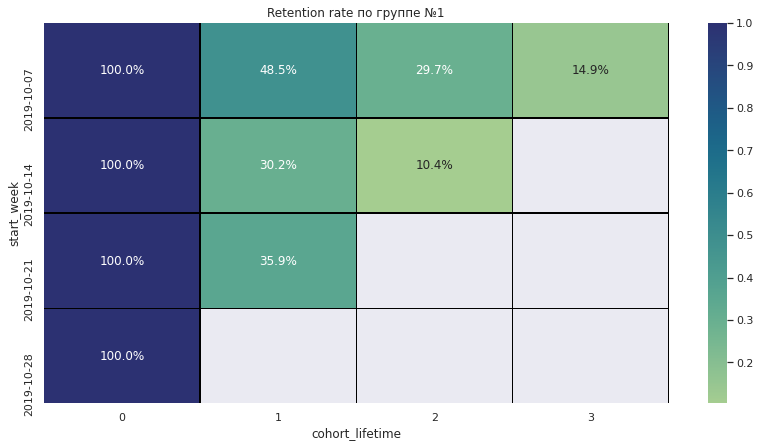

In [88]:
plt.figure(figsize=(14, 7))
plt.title('Retention rate по группе №1')
sns.heatmap(retention_pivot_1, annot=True, fmt='.1%', linewidths=0.2, linecolor='black', cmap="crest");

## RETENTION RATE для ГРУППЫ №2 <a class="anchor" id="rr_group2"></a>

In [89]:
group_2 = df.query('duration >= 2 and contacts_show == 0').groupby(['start_week','cohort_lifetime'])\
.agg({'user_id':'nunique'}).reset_index()

In [90]:
users_count_2 = group_2[group_2['cohort_lifetime'] == 0][['start_week','user_id']]

In [91]:
users_count_2 = users_count_2.rename(columns={'user_id':'cohort_users'})
group_2 = group_2.merge(users_count_2, on='start_week')

In [92]:
group_2['retention'] = group_2['user_id']/group_2['cohort_users']

In [93]:
group_2['start_week'] = group_2['start_week'].dt.date

In [94]:
retention_pivot_2 = group_2.pivot_table(index='start_week',columns='cohort_lifetime',values='retention',aggfunc='sum')

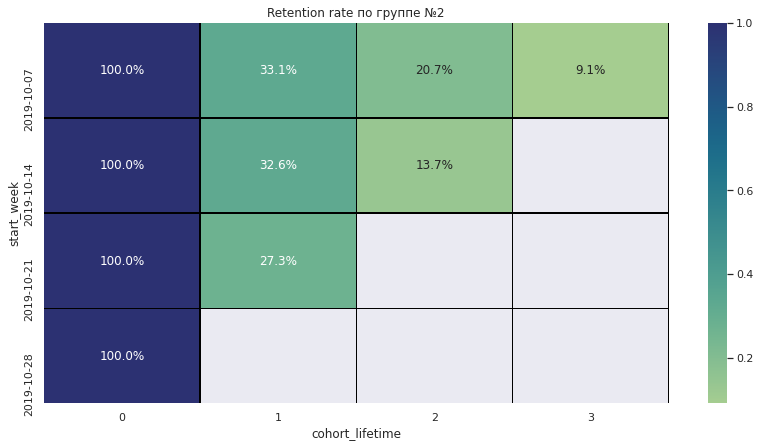

In [95]:
plt.figure(figsize=(14, 7))
plt.title('Retention rate по группе №2')
sns.heatmap(retention_pivot_2, annot=True, fmt='.1%', linewidths=0.2, linecolor='black', cmap="crest");

## RETENTION RATE для ГРУППЫ №3 <a class="anchor" id="rr_group3"></a>

In [96]:
group_3 = df.query('duration < 2 and contacts_show == 0').groupby(['start_week','cohort_lifetime'])\
.agg({'user_id':'nunique'}).reset_index()

In [97]:
users_count_3 = group_3[group_3['cohort_lifetime'] == 0][['start_week','user_id']]

In [98]:
users_count_3 = users_count_3.rename(columns={'user_id':'cohort_users'})
group_3 = group_3.merge(users_count_3, on='start_week')

In [99]:
group_3['retention'] = group_3['user_id']/group_3['cohort_users']

In [100]:
group_3['start_week'] = group_3['start_week'].dt.date

In [101]:
retention_pivot_3 = group_3.pivot_table(index='start_week',columns='cohort_lifetime',values='retention',aggfunc='sum')

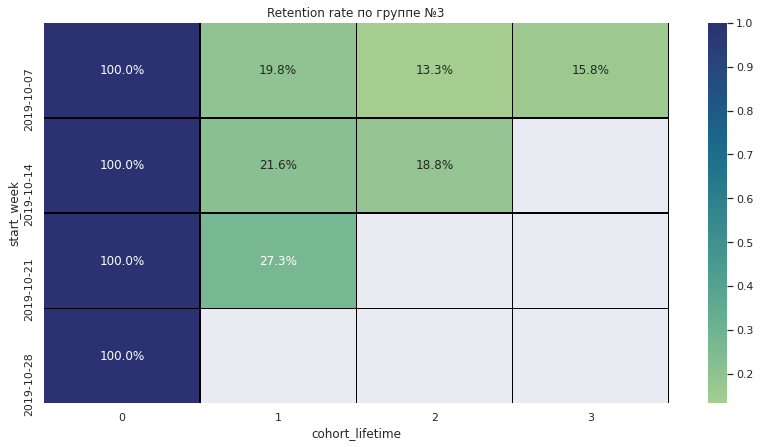

In [102]:
plt.figure(figsize=(14, 7))
plt.title('Retention rate по группе №3')
sns.heatmap(retention_pivot_3, annot=True, fmt='.1%', linewidths=0.2, linecolor='black', cmap="crest");

Глядя на графики, можно предположить, что поведение всех групп очень похоже на ранее построенный график коэффициента удержания по когортам. Retention Rate постепенно убывает с каждой неделей, но времени не досточно для корректного анализа этого показателя

### Промежуточный вывод после сегментации пользователей <a class="anchor" id="opinion3"></a>

Мы разделили пользователей на 3 группы в зависимости от их активности и достижения целевого действия(просмотра контакта):

Группа №1. Пользуются и смотрят контакты. В этой группе активные пользователи, достигают целевого действия, она не самая многочисленная, ее конечно необходимо привлекать в приложение и дальше, каким-то акциями или персональными предложениями

Группа №2. Пользуются приложением, но не смотрели контакты. Активные пользователи, но не интересуются контактами. Возможно не могут найти то, что им нужно или им недостаточно функционала приложения. Здесь можно было бы провести дополнительное исследование или провести опрос среди этих пользователей, возможно их что-то не устраивает.

Группа №3. Почти не пользуются, контакты не смотрели. Нужно найти какой-то способ, чтобы их вернуть в приложение. 

Глядя на графики, можно предположить, что Retention Rate постепенно убывает с каждой неделей, но времени не досточно для корректного анализа этого показателя, можно лишь увидеть, что от недели к неделе интерес пользователей меняется.

## Проверка статистических гипотез <a class="anchor" id="hypo"></a>

### Гипотеза №1. Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов <a class="anchor" id="h1"></a>

In [103]:
user_groups = user_groups.merge(mobile_sourсes, on='user_id')
user_groups

,user_id,duration,session_id,event_name,contacts_show,photos_show,tips_show,search,conversion,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,6.742857,35,35,0,0,1,0,0.00,other
1,00157779-810c-4498-9e05-a1e9e3cedf93,9.915493,71,71,11,1,0,1,0.15,yandex
2,00463033-5717-4bf1-91b4-09183923b9df,1.000000,10,10,0,1,0,0,0.00,yandex
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6.718750,32,32,0,0,1,1,0.00,google
4,00551e79-152e-4441-9cf7-565d7eb04090,2.625000,8,8,3,1,0,1,0.38,yandex
...,...,...,...,...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,8.647059,17,17,0,0,1,0,0.00,yandex
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1.000000,7,7,1,1,0,0,0.14,yandex
4290,ffcf50d9-293c-4254-8243-4890b030b238,1.000000,2,2,0,0,1,0,0.00,google
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,4.000000,13,13,1,1,0,1,0.08,yandex


In [104]:
source_yandex = user_groups.query('source == "yandex"')
source_google = user_groups.query('source == "google"')

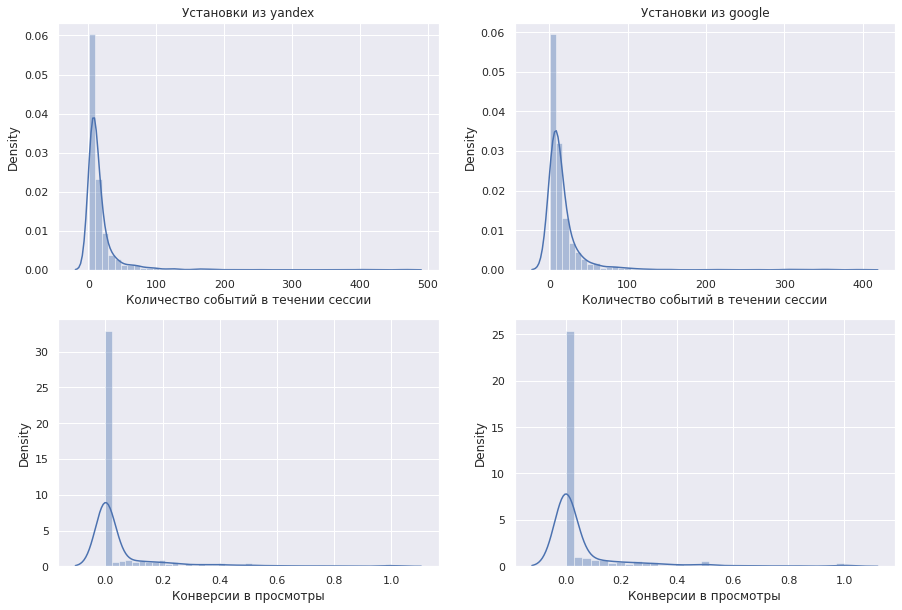

In [105]:
fig = plt.figure(figsize=(15,10))
area = fig.add_subplot(2, 2, 1)
ax = sns.distplot(source_yandex['event_name'])
ax.set_title("Установки из yandex")
ax.set_xlabel("Количество событий в течении сессии")

area = fig.add_subplot(2, 2, 2)
ax = sns.distplot(source_google['event_name'])
ax.set_title("Установки из google")
ax.set_xlabel("Количество событий в течении сессии")

area = fig.add_subplot(2, 2, 3)
ax = sns.distplot(source_yandex['conversion'])
ax.set_xlabel("Конверсии в просмотры")


area = fig.add_subplot(2, 2, 4)
ax=sns.distplot(source_google['conversion'])
ax.set_xlabel("Конверсии в просмотры");

**Формулировка нулевой гипотезы H0:** конверсии в просмотры контактов между теми пользователями, которые совершили установку приложения, прийдя с источника yandex и пользователями, совершившими установки, из источника google, равны

**Альтернативная гипотеза H1:** конверсии пользователей, совершивших установку из разных источников, различаются

In [106]:
alpha = .05

results = st.ttest_ind(
    source_yandex['conversion'], 
    source_google['conversion'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8223249874583107
Не получилось отвергнуть нулевую гипотезу


In [107]:
print('Средняя конверсия в просмотры контактов у пользователей yandex: {:.2%}'.format(source_yandex['conversion'].mean()))

print('Средняя конверсия в просмотры контактов у пользователей google: {:.2%}'.format(source_google['conversion'].mean()))


Средняя конверсия в просмотры контактов у пользователей yandex: 6.29%
Средняя конверсия в просмотры контактов у пользователей google: 6.42%


<div class="alert alert-info">  Разделили пользователей на группы по источнику установки приложения, сравнили их визуально и затем провели t-test, где определили, что нет оснований отвергать нулевую гипотезу о равенстве конверсий в просмотр контактов пользователей, совершивших установку из разных источников. Яндекс или Гугл - не имеет значения. </div>

### Гипотеза №2. Насколько хорошо работает система рекомендаций объявлений у приложения (tips_show), чем через обычный поиск (search). Различается ли конверсия этих двух событий в просмотр контакта (contacts_show) <a class="anchor" id="h2"></a>

In [108]:
tips_recc = user_groups.query('tips_show == 1')
search_app = user_groups.query('search == 1')

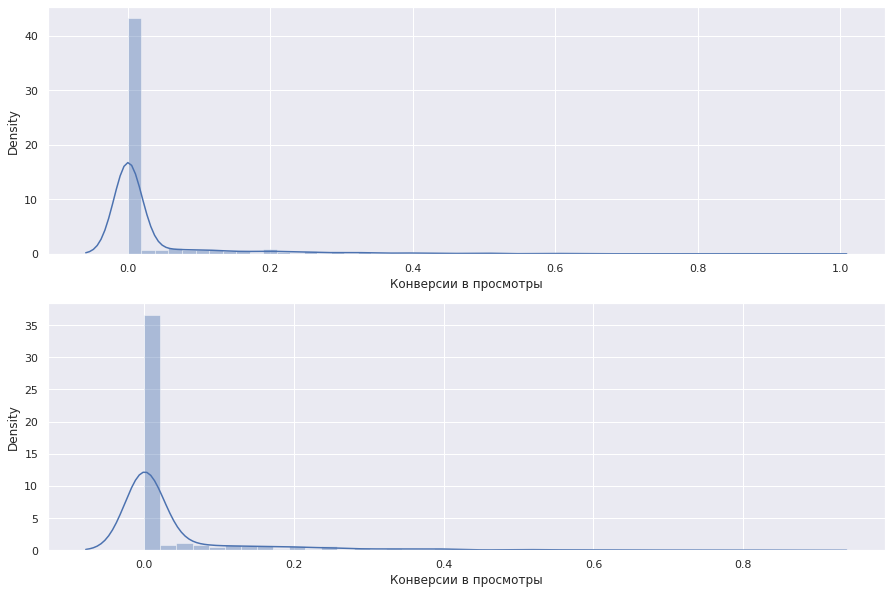

In [109]:
fig = plt.figure(figsize=(15,10))


area = fig.add_subplot(2, 1, 1)
ax = sns.distplot(tips_recc['conversion'])
ax.set_xlabel("Конверсии в просмотры")


area = fig.add_subplot(2, 1, 2)
ax=sns.distplot(search_app['conversion'])
ax.set_xlabel("Конверсии в просмотры");

**Формулировка нулевой гипотезы H0:** конверсии в просмотры контактов между теми пользователями, которым объявления предлагает система рекомендаций приложения и теми, кто использует обычный поиск - равны.

**Альтернативная гипотеза H1:** конверсии пользователей в просмотры контактов между рекомендациями и поиском - различаются

In [110]:
alpha = .05

results = st.ttest_ind(
    tips_recc['conversion'], 
    search_app['conversion'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0008233583593910834
Отвергаем нулевую гипотезу


<div class="alert alert-info">Конверсии пользователей в просмотры контактов между рекомендациями и поиском - различаются и у тех пользователей, которые пользуются поиском она выше</div>

In [111]:
print('Средняя конверсия в просмотры контактов у пользователей, которые пользуются рекомендациями: {:.2%}'.format(tips_recc['conversion'].mean()))
print('Средняя конверсия в просмотры контактов у пользователей, которые используют поиск: {:.2%}'.format(search_app['conversion'].mean()))

Средняя конверсия в просмотры контактов у пользователей, которые пользуются рекомендациями: 3.37%
Средняя конверсия в просмотры контактов у пользователей, которые используют поиск: 4.45%


### Выводы после проверки гипотез <a class="anchor" id="opinion4"></a>

- №1. Мы приняли нулевую гипотезу о том, что конверсии в просмотры контактов между теми пользователями, которые совершили установку приложения, прийдя с источника Яндекс и пользователями, совершившими установки, из источника Google, нет статистически значимой разницы и сделали вывод, что конверсии групп Google и Яндекс в просмотр контактов не различаются.


- №2. По результатам проверки мы отвергаем нулевую гипотезу и принимаем альтернативную о том, что конверсии пользователей в просмотры контактов между рекомендациями и поиском, имеют статистически значимую разницу, и делаем предположение, что конверсия в просмотры контактов у пользователей, которые используют поиск выше, чем у тех, кому помогает приложение с системой рекомендаций.

## Общие выводы и рекомендации <a class="anchor" id="opinion5"></a>

- У нас имеются данные с 07 октября по 03 ноября 2019 года, почти 28 дней. 4293 уникальных пользователя. События среди пользователей распределены равномерно по дням исследования;

- Поведение покупателей меняется с каждой неделей и retention rate уменьшается, но из-за недостаточного промежутка времени в исследовании, возможна погрешность и выводы поверхностны;

- Пользователь тратит где-то 15-16 минут на приложение за сессию. На каждого пользователя приходится от 1 до 5 сессий;

- Самые частые события - это tips_show пользователь увидел рекомендованные объявления, photos_show - просмотр фотографий в объявлении, search - поиск по сайту, advert_open - открытие карточки объявления;

- По нашим расчетам до события contacts_show доходят ~23% пользователей. 77% - достаточно большой отток от общего количества пришедших к нам пользователей. Возможно управление приложением не достаточно интуитивно и пользователь путается в большом количестве рекомендаций и приложение нужно как-то упростить;

- Мы разделили пользователей на 3 группы в зависимости от их активности и достижения целевого действия(просмотра контакта):

Группа №1. Пользуются и смотрят контакты. В этой группе активные пользователи, достигают целевого действия, она не самая многочисленная, ее конечно необходимо привлекать в приложение и дальше, каким-то акциями или персональными предложениями

Группа №2. Пользуются приложением, но не смотрели контакты. Активные пользователи, но не интересуются контактами. Возможно не могут найти то, что им нужно или им недостаточно функционала приложения. Здесь можно было бы провести дополнительное исследование или провести опрос среди этих пользователей, возможно их что-то не устраивает.

Группа №3. Почти не пользуются, контакты не смотрели. Нужно найти какой-то способ, чтобы их вернуть в приложение.

Глядя на графики, можно предположить, что Retention Rate постепенно убывает с каждой неделей, но времени не досточно для корректного анализа этого показателя, можно лишь увидеть, что от недели к неделе интерес пользователей меняется.

- Проверили гипотезы:
- №1. Мы приняли нулевую гипотезу о том, что конверсии в просмотры контактов между теми пользователями, которые совершили установку приложения, прийдя с источника Яндекс и пользователями, совершившими установки, из источника Google, нет статистически значимой разницы и сделали вывод, что конверсии групп Google и Яндекс в просмотр контактов не различаются;


- №2. По результатам проверки мы отвергаем нулевую гипотезу и принимаем альтернативную о том, что конверсии пользователей в просмотры контактов между рекомендациями и поиском, имеют статистически значимую разницу, и делаем предположение, что конверсия в просмотры контактов у пользователей, которые используют поиск выше, чем у тех, кому помогает приложение с системой рекомендаций.

**Рекомендации**

- В целом, в приложение необходимо добавить логи о начале и конце сессии, чтобы было удобнее анализировать действия пользователей;

- Возможно управление приложением не достаточно интуитивно понятно и пользователь путается в большом количестве рекомендаций и приложение нужно как-то упростить; 

- Конверсия в просмотры контактов у пользователей, которые используют поиск выше, чем у тех, кому помогает приложение с системой рекомендаций. Но количество событий по поиску значительно меньше среди пользователей, чем система рекомендаций. Значит нужно как-то привлечь внимание к кнопке поиска, сделать ее более заметной;

- Подумать над способами удержания тех пользователей, которые уже пользуются приложением, у нас есть группа №1 активных пользователей, но пользователи все равно уходят. Возможно, нужно разработать какое-то поощрение за пользование приложением или систему премиум-подписки.

## Презентация <a class="anchor" id="pres"></a>

### Ссылка на презентацию

[Презентация](https://disk.yandex.ru/i/pOIYFoj6YulUSA)

## Дашборд <a class="anchor" id="dashb"></a>

### Ссылка на дашборд

[Дашборд](https://public.tableau.com/app/profile/dmitriy2609/viz/mobile_apps_final/Dashboard1?publish=yes)